In [2]:
import cv2
import glob
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import scipy.io as sio

from eve import EVE

In [3]:
from data_normalization_code.normalize_data import normalizeData, estimateHeadPose

In [128]:
def plot_preds_3d(preds, img):
    plot_style = dict(marker='o',
                      markersize=4,
                      linestyle='-',
                      lw=2)

    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
                  'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
                  'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
                  'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
                  'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
                  'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
                  'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
                  'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
                  'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
                  }

    fig = plt.figure(figsize=plt.figaspect(.5))
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(img)

    for pred_type in pred_types.values():
        ax.plot(preds[pred_type.slice, 0],
                preds[pred_type.slice, 1],
                color=pred_type.color, **plot_style)

    ax.axis('off')

    # 3D-Plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.scatter(preds[:, 0] * 1.2,
                      preds[:, 1],
                      preds[:, 2],
                      c='cyan',
                      alpha=1.0,
                      edgecolor='b')

    for pred_type in pred_types.values():
        ax.plot3D(preds[pred_type.slice, 0] * 1.2,
                  preds[pred_type.slice, 1],
                  preds[pred_type.slice, 2], color='blue')

    ax.view_init(elev=90., azim=90.)
    ax.set_xlim(ax.get_xlim()[::-1])
    plt.show()

In [5]:
def calibrate(images):
    """
    :returns: (ret, mtx, dist, rvecs, tvecs)
    """
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objp = np.zeros((6*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
    objpoints = [] 
    imgpoints = []
    for img in images:        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    w, h = gray.shape[::-1]
    return cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)

In [14]:
def undistort_image(img, mtx, dist):
    plt.imshow(img)
    plt.show()
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, 
                                                      dist,
                                                      (w, h),
                                                      1,
                                                      (w, h))
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    x, y, w, h = roi
    plt.imshow(dst)
    plt.show()
    undistorted = dst[y:y+h, x:x+w]
    plt.imshow(undistorted)
    plt.show()
    return undistorted

# Pipeline for preprocessing as per EVE dataset

### Preprocessing steps:

1) intrinsic matrix calibration using opencv and ChArUco board [5]
2) extrinsic camera calibration using mirrors [1]
3) undistort the frames
4) detect face 
5) detect face-region landmarks (use face_alignment and blazeface)
6) perform 3D morphable model (3DMM) to 3D landmarks [2]
7) apply 'data normalization' for yielding eye patches [3, 4] under assumptions:
   - virtual camera is located 60cm away from the gaze origin
   - focal length of 1800mm


[1] https://www.jstage.jst.go.jp/article/ipsjtcva/8/0/8_11/_pdf/-char/en

[2] https://openresearch.surrey.ac.uk/discovery/delivery/44SUR_INST:ResearchRepository/12139198320002346#13140605970002346

[3] https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Sugano_Learning-by-Synthesis_for_Appearance-based_2014_CVPR_paper.pdf

[4] https://www.perceptualui.org/publications/zhang18_etra.pdf

[5] https://docs.opencv.org/4.5.2/dc/dbb/tutorial_py_calibration.html

In [7]:
np.set_printoptions(suppress=True)

In [19]:
images = [cv2.resize(cv2.imread(i), None, fx=1.25, fy=1.25)
          for i in glob.glob('./data/*.jpg')]

In [20]:
ret, mtx, dist, rvecs, tvecs = calibrate(images)

In [27]:
img = images[5]

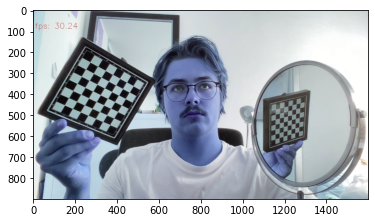

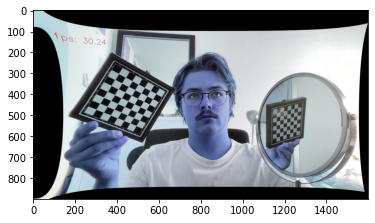

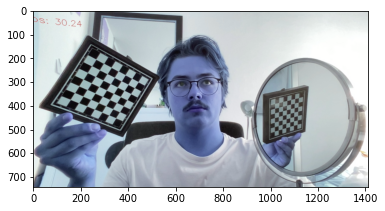

In [28]:
img = undistort_image(img, mtx, dist)

In [29]:
import collections
import face_alignment


In [33]:
fa2d = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D,
                                    flip_input=False,
                                    device='cpu',
                                    face_detector='blazeface')

In [34]:
[preds] = fa2d.get_landmarks(img)
preds = iter(preds[slice(48, 60)])
i = 0

In [ ]:
_img = img.copy()
plt.imshow(_img)
pred = next(preds)
plt.scatter(pred[0], pred[1])
print(i + 48)
i += 1

landmark indices:
- corner left left: 36
- corner left right: 39
- corner right left: 42
- corner right right: 45
- mouth left: 48
- mouth right: 54

In [36]:
[preds] = fa2d.get_landmarks(img)

In [37]:
landmarks = [preds[36], preds[39], preds[42], preds[45], preds[48], preds[54]]

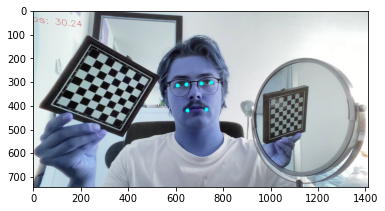

In [38]:
_img = img.copy()
plt.imshow(_img)
for i in landmarks:
    plt.scatter(i[0], i[1], color='cyan', marker='.')

In [41]:
gc = np.array([-127.790719, 4.621111, -12.025310])  # 3D gaze taraget position

In [42]:
mtx

array([[1151.43123638,    0.        ,  841.93001004],
       [   0.        , 1157.3606197 ,  462.98145844],
       [   0.        ,    0.        ,    1.        ]])

In [43]:
dist

array([[ 0.02318099, -0.14118779,  0.00304291, -0.0009262 , -0.07503769]])

In [44]:
def normalize(img, mtx, dist, landmarks, gc):
    landmarks = np.array(landmarks)
    _img = img.copy()
    _img = cv2.undistort(_img, mtx, dist)
    face = sio.loadmat('./data_normalization_code/data/faceModelGeneric.mat')['model']
    face_pts = face.T.reshape(face.shape[1], 1, 3)
    hr, ht = estimateHeadPose(landmarks, face_pts, mtx, dist)
    data = normalizeData(img, face, hr, ht, gc, mtx)
    return data

In [45]:
data = normalize(img, mtx, dist, landmarks, gc)

In [46]:
data

[[array([[104, 171, 209, ..., 112, 112, 116],
         [221, 235, 249, ...,  66,  90, 107],
         [247, 252, 252, ...,   5,  27,  66],
         ...,
         [243, 243, 243, ..., 184, 190, 186],
         [249, 249, 249, ..., 190, 192, 184],
         [252, 251, 251, ..., 198, 202, 195]], dtype=uint8),
  array([[ 0.011142  ],
         [ 0.27624541],
         [-0.00154884]]),
  array([[-0.17316456],
         [-0.01043395],
         [-0.98483764]])],
 [array([[178, 184, 187, ...,  51,  54,  62],
         [196, 194, 198, ..., 122,  69,  48],
         [204, 204, 205, ..., 224, 214, 204],
         ...,
         [215, 222, 211, ..., 246, 246, 245],
         [234, 244, 228, ..., 249, 249, 247],
         [237, 248, 241, ..., 250, 250, 248]], dtype=uint8),
  array([[ 0.01118047],
         [ 0.18767072],
         [-0.00105222]]),
  array([[-0.17472383],
         [-0.01048791],
         [-0.98456162]])]]

(36, 120)

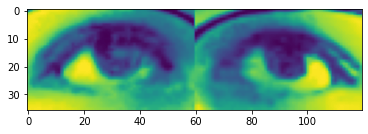

In [50]:
eyes_cat = np.concatenate((data[0][0], data[1][0]), axis=1)
plt.imshow(eyes_cat)
eyes_cat.shape